## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from glob import glob
import numpy as np

from datetime import datetime

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004), apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [2]:
path_train = "/glade/scratch/hgamarro/Deep_learning/Final_Project/data/interim/Vegas_v1/train/"
path_val = "/glade/scratch/hgamarro/Deep_learning/Final_Project/data/interim/Vegas_v1/train/"

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [4]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    return images, masks


def load_image_mask(image_file,mask_file):
    input_image = tf.io.read_file(image_file)
    input_image = tf.image.decode_png(input_image)
    
    mask_image = tf.io.read_file(mask_file)
    mask_image = tf.image.decode_png(mask_image)


    input_image = tf.cast(input_image, tf.float32)
    mask_image = tf.cast(mask_image, tf.float32)

    return input_image, mask_image

def resize(input_image, mask_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_image = tf.image.resize(mask_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, mask_image

def normalize(input_image, mask_image):
    input_image = (input_image / 255)
    mask_image = (mask_image / 1) 

    return input_image, mask_image



In [5]:
def load_image_train(image_file,mask_file):
    input_image, mask_image = load_image_mask(image_file,mask_file)
    input_image, mask_image = resize(input_image, mask_image,
                                   IMG_WIDTH, IMG_HEIGHT)
    input_image, mask_image = normalize(input_image, mask_image)
    return input_image, mask_image

In [6]:
def load_image_test(image_file,mask_file):
    input_image, mask_image = load_image_mask(image_file,mask_file)
    input_image, mask_image = resize(input_image, mask_image,
                                   IMG_WIDTH, IMG_HEIGHT)
    input_image, mask_image = normalize(input_image, mask_image)
    return input_image, mask_image

## Input Pipeline

In [7]:
train_images_list, train_masks_list = load_data(path_train)
print(f"Images: {len(train_images_list)} - Masks: {len(train_masks_list)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_list, train_masks_list))
train_dataset = train_dataset.map(load_image_test)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Images: 2303 - Masks: 2303


In [8]:
val_images_list, val_masks_list = load_data(path_train)
print(f"Images: {len(val_images_list)} - Masks: {len(val_masks_list)}")

test_dataset = tf.data.Dataset.from_tensor_slices((val_images_list, val_masks_list))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Images: 2303 - Masks: 2303


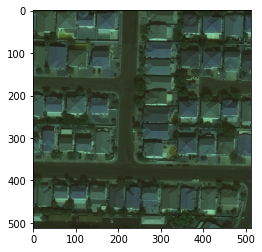

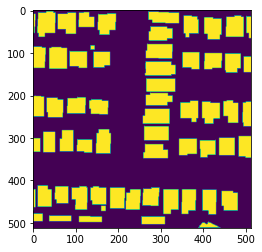

In [9]:
inp, re = load_image_train(train_images_list[100], train_masks_list[100])
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp)
plt.figure()
plt.imshow(re)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [10]:
OUTPUT_CHANNELS = 1

In [11]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [13]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [16]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        #downsample(64, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        #upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
        

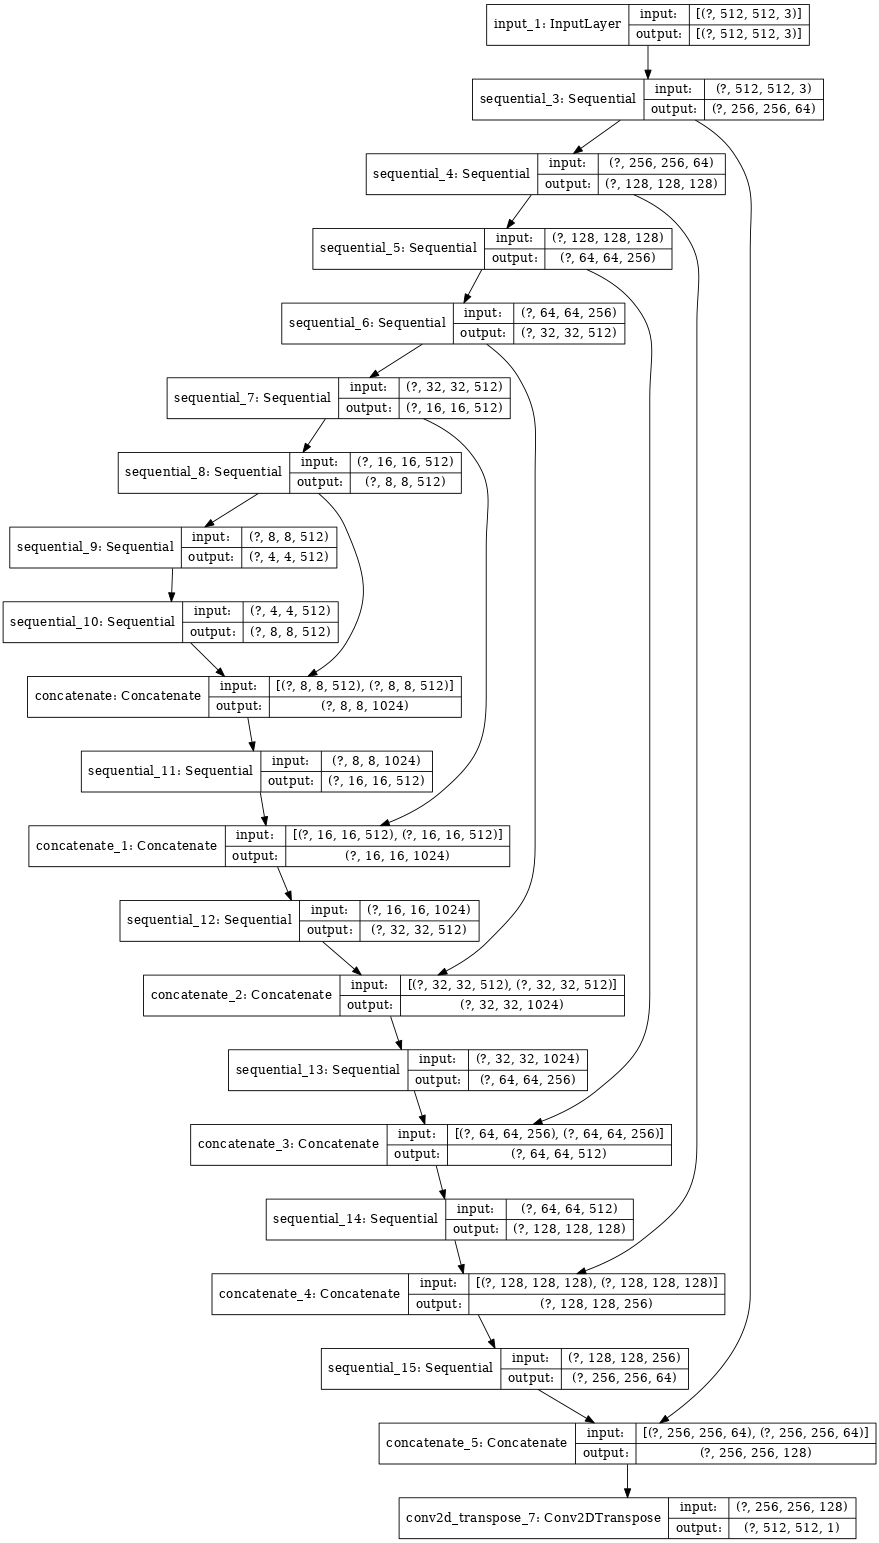

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

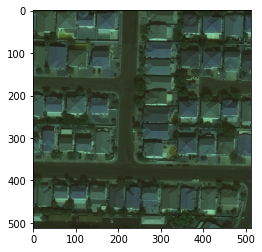

In [20]:
plt.imshow(inp)

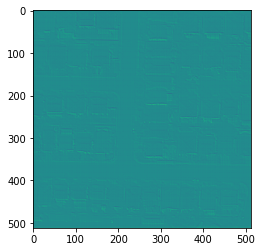

In [21]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [22]:
LAMBDA = 100

In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * Concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [25]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
    tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512*2, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
        

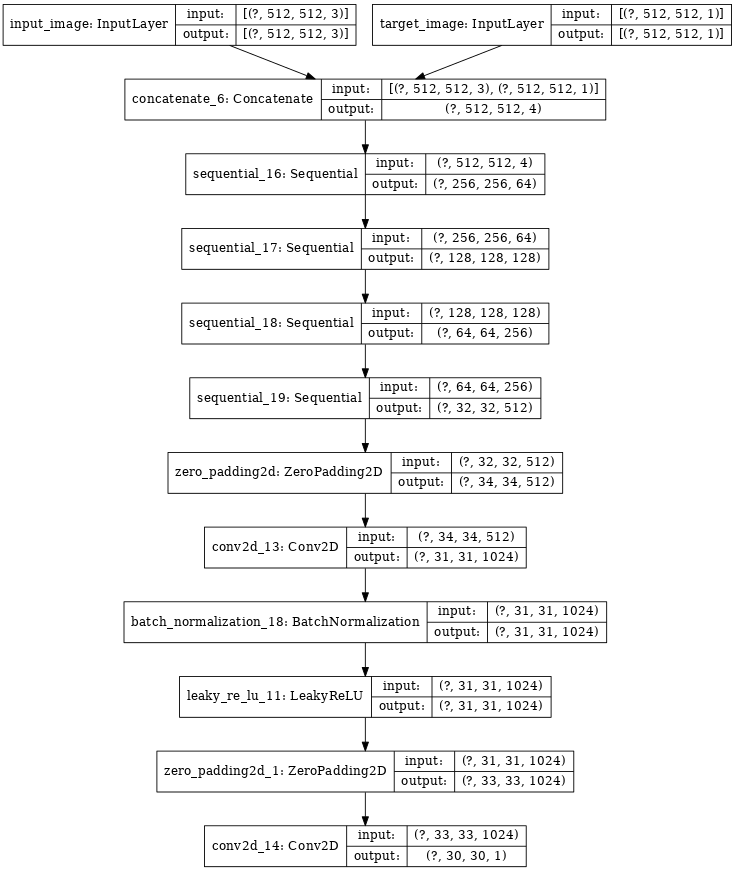

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [27]:
# def Discriminator():
#     initializer = tf.random_normal_initializer(0., 0.02)

#     inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
#     tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

#     x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

#     down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
#     down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
#     down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
#     down4 = downsample(512, 4)(down2)  # (bs, 32, 32, 256)

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
#     conv = tf.keras.layers.Conv2D(512, 4, strides=1,
#                                 kernel_initializer=initializer,
#                                 use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

#     batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

#     leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

#     last = tf.keras.layers.Conv2D(1, 4, strides=1,
#                                 kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

#     with mirrored_strategy.scope():
#         return tf.keras.Model(inputs=[inp, tar], outputs=last)

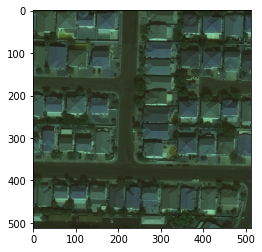

In [28]:
plt.imshow(inp)

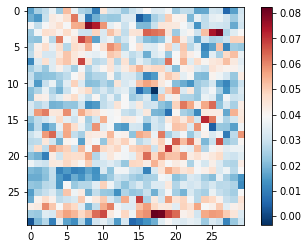

In [29]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Validate Images

In [29]:
def IOUscore(tar ,pred):
    
    bool_tar = np.array(tar ,dtype=bool)
    bool_pred = np.array(tf.math.greater(pred ,.5))
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = bool_tar * bool_pred
    union = bool_tar + bool_pred
    return intersection.sum() / union.sum()

In [30]:
def val_images(model, test_input, tar):
    prediction = model(test_input, training=False)
#     iou_score = IOUscore(tar ,prediction)
    
    iou_score = metrics[0](prediction, tar)
    f1_score = metrics[1](prediction, tar)
    
    return iou_score, f1_score

In [233]:
# start = datetime.now()

# sum_iou = []
# for example_input, example_target in test_dataset.take(10):
#     prediction = generator(example_input, training=False )
    
#     metrics.update_state(example_target,prediction , sample_weight=None)
#     sum_iou.append(metrics.result().numpy())
#     metrics.reset_states()
    
# iou_average = np.average(sum_iou)

# end = datetime.now()
# print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:10.335324


## Generate Images

Write a function to plot some images during training.

* Pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
you want the batch statistics while running the model
on the test dataset. If you use training=False, you get
the accumulated statistics learned from the training dataset
(which you don't want)

In [31]:
def generate_images(model, test_input, tar):
    
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [38]:
EPOCHS = 5
metrics = tf.keras.metrics.MeanIoU(num_classes=2)

In [56]:
# import datetime
# log_dir="/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [34]:
checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Restore the latest checkpoint and test

In [48]:
!ls {checkpoint_dir}

checkpoint		     ckpt-22.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-22.index
ckpt-10.index		     ckpt-23.data-00000-of-00001
ckpt-11.data-00000-of-00001  ckpt-23.index
ckpt-11.index		     ckpt-24.data-00000-of-00001
ckpt-12.data-00000-of-00001  ckpt-24.index
ckpt-12.index		     ckpt-25.data-00000-of-00001
ckpt-13.data-00000-of-00001  ckpt-25.index
ckpt-13.index		     ckpt-26.data-00000-of-00001
ckpt-14.data-00000-of-00001  ckpt-26.index
ckpt-14.index		     ckpt-2.data-00000-of-00001
ckpt-15.data-00000-of-00001  ckpt-2.index
ckpt-15.index		     ckpt-3.data-00000-of-00001
ckpt-16.data-00000-of-00001  ckpt-3.index
ckpt-16.index		     ckpt-4.data-00000-of-00001
ckpt-17.data-00000-of-00001  ckpt-4.index
ckpt-17.index		     ckpt-5.data-00000-of-00001
ckpt-18.data-00000-of-00001  ckpt-5.index
ckpt-18.index		     ckpt-6.data-00000-of-00001
ckpt-19.data-00000-of-00001  ckpt-6.index
ckpt-19.index		     ckpt-7.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-7.index
ckpt-1.index		

In [35]:
# restoring the latest checkpoint in checkpoint_dir

final_checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints/ckpt-20'

checkpoint.restore(final_checkpoint_dir)

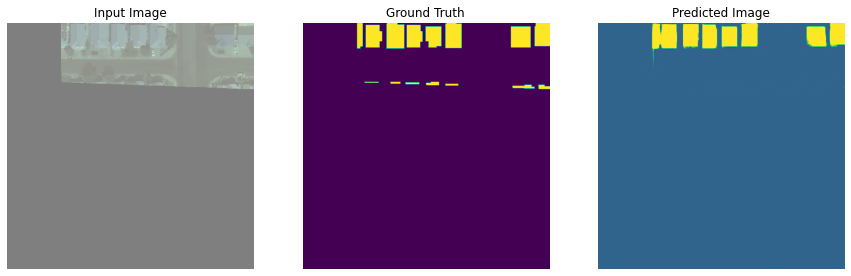

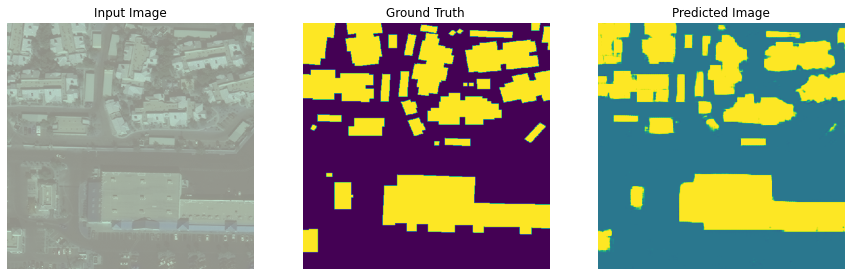

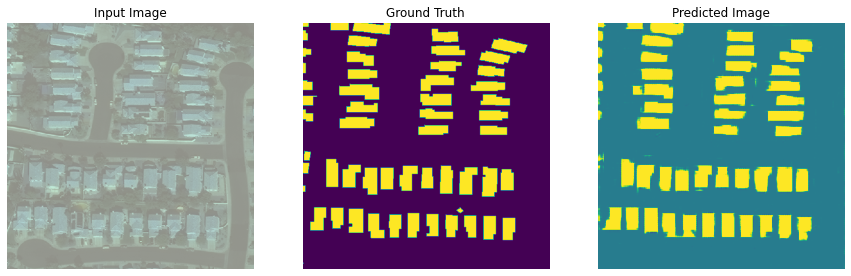

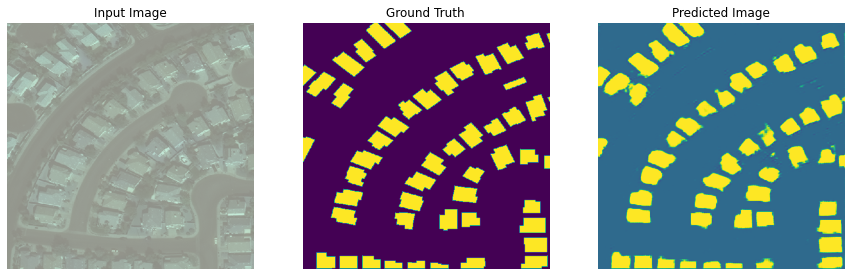

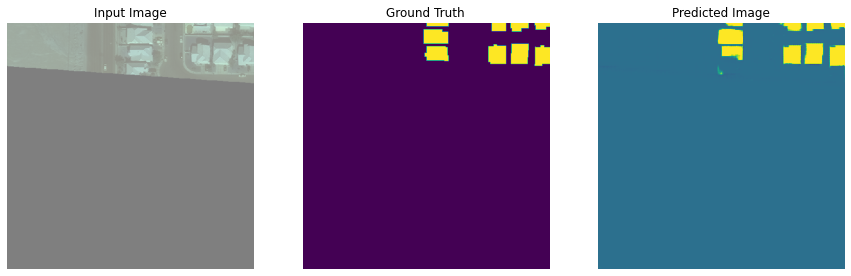

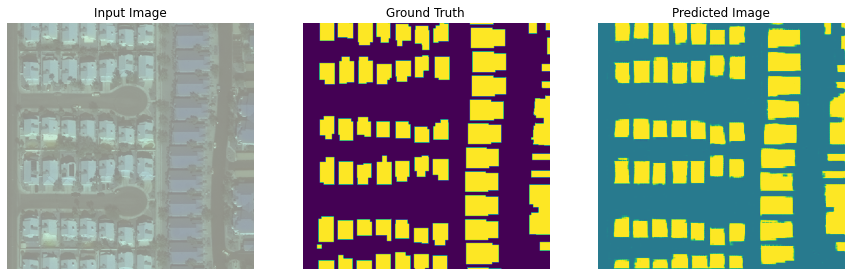

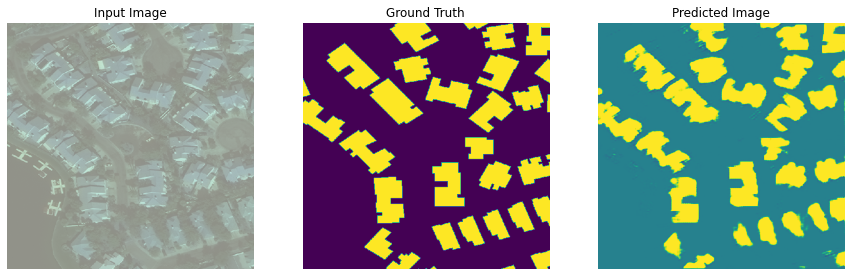

In [36]:
for example_input, example_target in test_dataset.take(7):
    generate_images(generator, example_input, example_target)

In [118]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.nn.relu(tf.round(x * multiplier) / multiplier)

In [119]:
metrics = tf.keras.metrics.MeanIoU(num_classes=2)
metrics_pre = tf.keras.metrics.Recall()
metrics_rec = tf.keras.metrics.Precision()


print("Calculating Validation")
sum_iou = []
sum_pre = []
sum_rec = []

for example_input, example_target in test_dataset.take(len(test_dataset)):
    prediction = generator(example_input, training=False )

    metrics.update_state(example_target,my_tf_round(prediction) , sample_weight=None)
    sum_iou.append(metrics.result().numpy())
    metrics.reset_states()
    
    
    metrics_pre.update_state(example_target,my_tf_round(prediction), sample_weight=None)
    sum_pre.append(metrics_pre.result().numpy())
    metrics_pre.reset_states()
    
    
    metrics_rec.update_state(example_target,my_tf_round(prediction), sample_weight=None)
    sum_rec.append(metrics_rec.result().numpy())
    metrics_rec.reset_states()

iou_average = np.average(sum_iou)
rec_average = np.average(sum_rec)
pre_average = np.average(sum_pre)

print(iou_average)
print(rec_average)
print(pre_average)

Calculating Validation
0.8761718
0.8907013
0.8938706


In [125]:
f1_score = rec_average * pre_average *2 / (rec_average + pre_average)
print(f1_score)

0.8922830975985824


## Generate using test dataset

In [73]:
generator_ex = generator(example_input,training=False)
disc_real_output_ex = discriminator([example_input, example_target], training=False)
disc_generated_output_ex = discriminator([example_input, generator_ex], training=False)

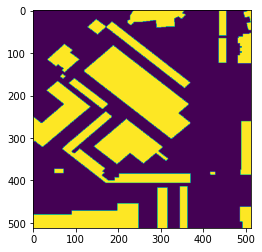

In [116]:
idxx = 27
plt.imshow(example_target[idxx])


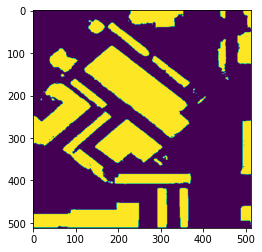

In [117]:
plt.imshow(my_tf_round(generator_ex[idxx]))

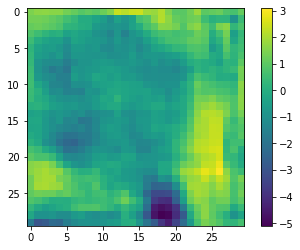

In [120]:
plt.imshow(disc_real_output_ex[idxx])
plt.colorbar()

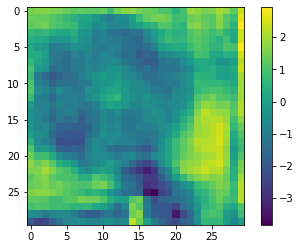

In [121]:
plt.imshow(disc_generated_output_ex[idxx])
plt.colorbar()

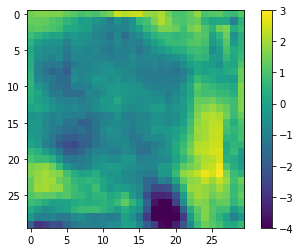

In [122]:
aa = -4
bb=3
plt.imshow(disc_real_output_ex[idxx],vmin=aa, vmax=bb,)
plt.colorbar()

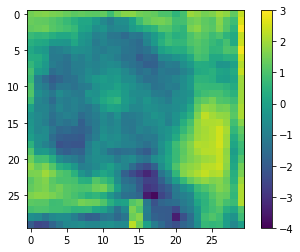

In [123]:
plt.imshow(disc_generated_output_ex[idxx],vmin=aa, vmax=bb,)
plt.colorbar()